In [263]:
from __future__ import annotations
import pandas as pd, numpy as np, pathlib, functools, sys

# ────────────────────────────────────────────────────────────────
# 1.  ROOT DIRECTORY  (edit once)
# ────────────────────────────────────────────────────────────────
ROOT = pathlib.Path(
    r"C:\Github_Projects\PhysionetData\physionet.org"
)

# ────────────────────────────────────────────────────────────────
# 2.  SUBSET HELPER
# ────────────────────────────────────────────────────────────────
def _load_subset(letter: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    letter : 'a', 'b', or 'c'
    Returns X_subset, y_subset
    """
    set_dir   = ROOT / f"set-{letter}"
    outcome_f = ROOT / f"Outcomes-{letter}.txt"

    if not set_dir.is_dir() or not outcome_f.is_file():
        sys.exit(f"[ERROR] Missing {letter.upper()} files at {set_dir} / {outcome_f}")

    labels = (
        pd.read_csv(outcome_f)
          .set_index("RecordID")["In-hospital_death"]
          .astype(int)
    )

    patient_files = sorted(set_dir.glob("*.txt"))
    feats, ys = [], []

    for fp in patient_files:
        rid = int(fp.stem)
        if rid not in labels.index:
            continue
        df  = pd.read_csv(fp)                          # Time,Parameter,Value
        df["Value"] = pd.to_numeric(df["Value"], errors="coerce").replace(-1, np.nan)

        s = df.groupby("Parameter")["Value"].mean()    # mean over all times
        s.name = rid                                   # RecordID becomes index
        s = s.drop(labels="RecordID", errors="ignore") # UID not a feature

        feats.append(s)
        ys.append(labels.at[rid])

    X_sub = pd.DataFrame(feats).astype(float)
    y_sub = pd.Series(ys, index=X_sub.index, name="death")

    print(f"[INFO] subset {letter.upper()}: {X_sub.shape[0]} patients loaded")
    return X_sub, y_sub

# ────────────────────────────────────────────────────────────────
# 3.  LOAD A, B, C AND CONCAT
# ────────────────────────────────────────────────────────────────
def load_all_abc() -> tuple[pd.DataFrame, pd.Series]:
    X_parts, y_parts = [], []
    for letter in ("a", "b", "c"):
        X_i, y_i = _load_subset(letter)
        X_parts.append(X_i)
        y_parts.append(y_i)

    X_all = pd.concat(X_parts, axis=0, join="outer").astype(float)
    y_all = pd.concat(y_parts, axis=0).astype(float)

    print(f"[INFO] total: {X_all.shape[0]} patients, {X_all.shape[1]} features")
    return X_all.reset_index(drop=True), y_all.reset_index(drop=True)



In [264]:
X, y = load_all_abc()

# ensure alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# add Outcome column at the end
X["Outcome"] = y

X.head()

[INFO] subset A: 4000 patients loaded
[INFO] subset B: 4000 patients loaded
[INFO] subset C: 4000 patients loaded
[INFO] total: 12000 patients, 41 features


Parameter,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,ALP,ALT,AST,Albumin,Bilirubin,Lactate,Cholesterol,TroponinI,TroponinT,Outcome
0,54.0,10.500000,0.750000,14.923077,0.0,160.000000,27.000000,32.500000,70.810811,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,76.0,18.333333,1.100000,13.333333,1.0,125.500000,22.333333,28.655556,80.794118,175.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,44.0,4.666667,0.333333,5.923077,0.0,134.333333,25.000000,28.460000,83.759259,NaN,...,116.0,83.0,199.5,2.5,2.9,1.366667,NaN,NaN,NaN,0.0
3,68.0,17.666667,0.766667,14.944444,1.0,117.333333,27.666667,37.442857,70.983333,180.3,...,105.0,12.0,15.0,4.4,0.2,NaN,NaN,NaN,NaN,0.0
4,88.0,35.000000,1.000000,15.000000,0.0,102.500000,19.000000,29.550000,74.958333,NaN,...,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,0.0


In [265]:
X.to_csv("physionet_data.csv", index=False)

In [235]:
X.shape

(12000, 41)

In [182]:
# df : your pandas DataFrame
nan_counts = X.isna().sum()        # Series: index = column names, value = #NaNs

# if you want it as a sorted table:
nan_counts.sort_values(ascending=False).to_frame("NaN_count")

,NaN_count
Parameter,
TroponinI,11435
Cholesterol,11052
TroponinT,9363
RespRate,8672
Albumin,7129
ALP,6903
ALT,6787
AST,6786
Bilirubin,6786


In [183]:
np.unique(y, return_counts=True)


(array([0, 1]), array([10293,  1707]))

[INFO] kept 12000 / 12000 patients after filtering

Accuracy : 0.776
F1 score : 0.473


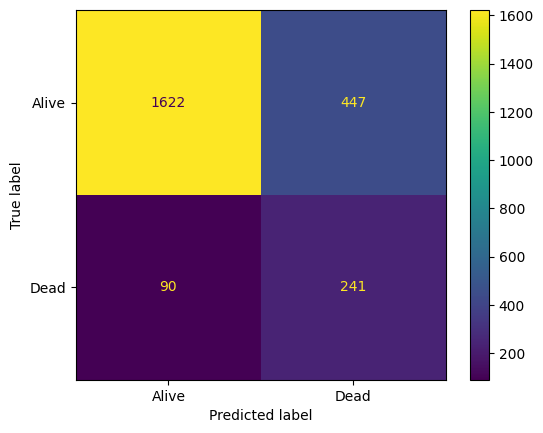

In [236]:
# prerequisites
# !pip install scikit-learn matplotlib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# ------------------------------------------------------------------
# 0.  assume X, y are already in memory
#     X : 41 features, NaN = missing   (sentinel -1 already -> NaN)
# ------------------------------------------------------------------

# ────────────────────────────────────────────────────────────────
# 1.  filter patients with ≤ 80 % missing
# ────────────────────────────────────────────────────────────────
row_missing = X.isna().mean(axis=1)
keep        = row_missing <= 1.0

X_f = X.loc[keep].reset_index(drop=True)
y_f = y.loc[keep].reset_index(drop=True)

print(f"[INFO] kept {X_f.shape[0]} / {X.shape[0]} patients after filtering")

# ────────────────────────────────────────────────────────────────
# 2.  build value‑plus‑mask feature matrix
# ────────────────────────────────────────────────────────────────
#mask_part = X_f.notna().astype(float)
#mask_part.columns = mask_part.columns + "_mask"

# 2) create the value matrix where NaN → 0
value_part = X_f.fillna(-1.0)
X_full = value_part

# 3) concatenate  (41 value cols + 41 mask cols)
#X_full = pd.concat([value_part, mask_part], axis=1)


#print(f"[INFO] final feature dim: {X_full.shape[1]} (41 values + 41 masks)")

# ────────────────────────────────────────────────────────────────
# 3.  split
# ────────────────────────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X_full, y_f,
    test_size=0.20,
    #stratify=y_f,
    random_state=42
)

# ────────────────────────────────────────────────────────────────
# 4.  pipeline: scale → Gradient Boosting
# ────────────────────────────────────────────────────────────────
pipe = RandomForestClassifier(
    n_estimators=400,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)

pipe.fit(X_tr, y_tr)

# ────────────────────────────────────────────────────────────────
# 5.  evaluation
# ────────────────────────────────────────────────────────────────
y_pred = pipe.predict(X_te)

acc = accuracy_score(y_te, y_pred)
f1  = f1_score(y_te, y_pred)

print(f"\nAccuracy : {acc:.3f}")
print(f"F1 score : {f1:.3f}")

cm = confusion_matrix(y_te, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Alive", "Dead"]).plot()


In [195]:
np.unique(y_te, return_counts=True)


(array([0, 1]), array([2056,  341]))

In [196]:
np.unique(y_pred, return_counts=True)


(array([0, 1]), array([2238,  159]))

In [198]:
X_tr

Parameter,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,pH_mask,ALP_mask,ALT_mask,AST_mask,Albumin_mask,Bilirubin_mask,Lactate_mask,Cholesterol_mask,TroponinI_mask,TroponinT_mask
4064,88.0,40.333333,1.400000,14.357143,0.0,141.666667,22.333333,31.366667,98.700000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11093,25.0,5.333333,0.733333,12.466667,0.0,96.000000,21.333333,37.000000,98.204545,180.3,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2188,64.0,22.000000,0.600000,14.818182,0.0,147.000000,29.333333,30.300000,111.716981,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2173,75.0,14.750000,0.700000,14.750000,1.0,115.250000,27.750000,27.981818,89.900000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8402,81.0,25.333333,0.866667,14.818182,0.0,112.333333,27.666667,30.833333,66.000000,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,57.0,14.500000,0.533333,15.000000,0.0,120.000000,24.000000,39.000000,93.785714,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4711,84.0,17.000000,0.800000,8.800000,1.0,173.333333,26.000000,30.300000,85.952381,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6298,54.0,14.000000,0.700000,11.823529,1.0,144.000000,25.000000,31.400000,89.370370,160.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6238,76.0,15.666667,0.866667,15.000000,1.0,106.000000,23.666667,34.400000,75.333333,177.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
import pandas as pd

# 1. extract raw importances and feature names
importances = pipe.feature_importances_        # array of length n_features
feat_names  = X_tr.columns                     # Index of your 41 (or 82) features

# 2. build a pandas Series and sort descending
imp_series = (
    pd.Series(importances, index=feat_names, name="importance")
      .sort_values(ascending=False)
)

# 3. print them out
print(imp_series.to_string())


Parameter
GCS                 1.460209e-01
Urine               7.106556e-02
BUN                 5.275795e-02
Age                 4.725706e-02
HR                  3.778973e-02
FiO2                3.156225e-02
Temp                3.152707e-02
Platelets           3.087375e-02
Lactate             3.021719e-02
Na                  2.961481e-02
Bilirubin           2.856340e-02
WBC                 2.791048e-02
Glucose             2.550198e-02
ALP                 2.510414e-02
HCO3                2.494060e-02
pH                  2.475833e-02
PaCO2               2.415391e-02
Creatinine          2.382482e-02
Weight              2.105421e-02
PaO2                2.086904e-02
HCT                 2.062427e-02
NISysABP            1.797753e-02
NIDiasABP           1.675596e-02
ICUType             1.658781e-02
SysABP              1.564082e-02
K                   1.517457e-02
NIMAP               1.509545e-02
Mg                  1.476404e-02
MAP                 1.360452e-02
RespRate            1.258649e-02


In [202]:
print(imp_series.head(10).to_frame())

           importance
Parameter            
GCS          0.146021
Urine        0.071066
BUN          0.052758
Age          0.047257
HR           0.037790
FiO2         0.031562
Temp         0.031527
Platelets    0.030874
Lactate      0.030217
Na           0.029615
